# Job Shop Scheduling

**Implementation Note:** The following cell specifies the solver to used in the subsequent calculations. Some of these problems can become quite larger, and therefore the `gurobi` solver has been set as a default. If you don't have the `gurobi` solver then adjust the code to use the `glpk` solver, but know the calculations may take longer (and the benchmark problem will not solve at all). If you do have the `gurobi` solver, edit the location of the executable to match the location on your computer.

In [0]:
%%capture
!pip install -q pyomo
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq coinor-cbc

In [0]:
from pyomo.environ import *
from pyomo.gdp import *

#solver = SolverFactory('glpk')
solver = SolverFactory('cbc', executable='/usr/bin/cbc')
#solver = SolverFactory('gurobi', executable='/usr/local/bin/gurobi.sh')

## Contents

* [Background](#Background)
* [Job Shop Example](#JobShopExample)
* [Task Decomposition](#TaskDecomposition)
* [Model Formulation](#ModelFormulation)
* [Pyomo Implementation](#PyomoImplementation)
* [Displaying a Solution](#DisplayingSolution)
* [Visualzing Results using Gantt Charts](#Visualization)
* [Appication to Scheduling of Batch Processes](#BatchProcesses)
    * [Single Product Strategies](#SingleProduct)
    * [Overlapping Tasks](#OverlappingTasks)
    * [Unit Cleanout](#UnitCleanout)
    * [Zero-Wait Policy](#ZeroWait)
* [Benchmark Problem LA19](#Benchmark)

<a id="Background"></a>
## Background

A job shop consists of a set of distinct machines that process jobs. Each job is a series of tasks that require use of particular machines for known durations, and which must be completed in specified order. The job shop scheduling problem is to schedule the jobs on the machines to minimize the time necessary to process all jobs (i.e, the makespan) or some other metric of productivity. Job shop scheduling is one of the classic problems in Operations Research. 

Data consists of two tables. The first table is decomposition of the jobs into a series of tasks. Each task lists a job name, name of the required machine, and task duration. The second table list task pairs where the first task must be completed before the second task can be started. This formulation is quite general, but can also specify situations with no feasible solutions.  

<a id="JobShopExample"></a>
## Job Shop Example

The following example of a job shop is from from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Dash Optimization, 2000.

In this example, there are three printed paper products that must pass through color printing presses in a particular order. The given data consists of a flowsheet showing the order in which each job passes through the color presses

![jobshopdiagram.jpg](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/images/jobshopdiagram.jpg?raw=1)

and a table of data showing, in minutes, the amount of time each job requires on each machine.

| Machine | Color | Paper 1 | Paper 2 | Paper 3 |
| :-----: | :---: | :-----: | :-----: | :-----: |
| 1       | Blue  | 45      | 20      | 12      |
| 2       | Green | -       | 10      | 17      |
| 3       | Yellow| 10      | 34      | 28      |

What is the minimum amount of time (i.e, what is the makespan) for this set of jobs?

<a id="TaskDecomposition"></a>
## Task Decomposition

The first step in the analysis is to decompose the process into a series of tasks. Each task is a (job,machine) pair. Some tasks cannot start until a prerequisite task is completed.

| Task (Job,Machine) | Duration | Prerequisite Task |
| :----------------: | :------: | :---------------: |
| (Paper 1, Blue)    | 45       | -                 |
| (Paper 1, Yellow)  | 10       | (Paper 1,Blue)    |
| (Paper 2, Blue)    | 20       | (Paper 2, Green)  |
| (Paper 2, Green)   | 10       | -                 |
| (Paper 2, Yellow)  | 34       | (Paper 2, Blue)   |
| (Paper 3, Blue)    | 12       | (Paper 3, Yellow) |
| (Paper 3, Green)   | 17       | (Paper 3, Blue)   |
| (Paper 3, Yellow)  | 28       | -                 |

We convert this to a JSON style representation where tasks are denoted by (Job,Machine) tuples in Python. The task data is stored in a Python dictionary indexed by (Job,Machine) tuples. The task data conists of a dictionary with duration ('dur') and (Job,Machine) pair for any prerequisite task.

In [0]:
TASKS = {
    ('Paper_1','Blue')   : {'dur': 45, 'prec': None},
    ('Paper_1','Yellow') : {'dur': 10, 'prec': ('Paper_1','Blue')},
    ('Paper_2','Blue')   : {'dur': 20, 'prec': ('Paper_2','Green')},
    ('Paper_2','Green')  : {'dur': 10, 'prec': None},
    ('Paper_2','Yellow') : {'dur': 34, 'prec': ('Paper_2','Blue')},
    ('Paper_3','Blue')   : {'dur': 12, 'prec': ('Paper_3','Yellow')},
    ('Paper_3','Green')  : {'dur': 17, 'prec': ('Paper_3','Blue')},
    ('Paper_3','Yellow') : {'dur': 28, 'prec': None},   
}

<a id="ModelFormulation"></a>
## Model Formulation

Each task is represented as an ordered pair $(j,m)$ where $j$ is a job, and $m$ is a machine.

| Parameter | Description |
| :-------- | :-----------|
| $\text{dur}_{j,m}$ | Duration of task $(j,m)$ | 
| $\text{prec}_{j,m}$ | A task $(k,n) = \text{Prec}_{j,m}$ that must be completed before task $(j,m)$| 

| Decision Variables | Description |
| :-------- | :-----------|
| $\text{makespan}$  | Completion of all jobs | 
| $\text{start}_{j,m}$ | Start time for task $(j,m)$ |
| $y_{j,k,m}$ | boolean variable for tasks $(i,m)$ and $(j,m)$ on machine $m$ where $j < k$ |

Upper and lower bounds on the start and completion of task $(j,m)$

\begin{align}
\text{start}_{j,m} & \geq 0\\
\text{start}_{j,m}+\text{Dur}_{j,m} & \leq \text{makespan}
\end{align}

Satisfying prerequisite tasks

\begin{align}
\text{start}_{k,n}+\text{Dur}_{k,n}\leq\text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{Prec}_{j,m}
\end{align}

Disjunctive Constraints

If $M$ is big enough, then satisfying
\begin{align}
\text{start}_{j,m}+\text{Dur}_{j,m} & \leq \text{start}_{k,m}+M(1 - y_{j,k,m})\\
\text{start}_{k,m}+\text{Dur}_{k,m} & \leq \text{start}_{j,m}+My_{j,k,m}
\end{align}

avoids conflicts for use of the same machine. 

<a id="PyomoImplementation"></a>
## Pyomo Implementation

The job shop scheduling problem is implemented below in Pyomo. The implementation consists of of a function JobShop(TASKS) that accepts a dictionary of tanks and returns a pandas dataframe containing an optimal schedule of tasks. An optional argument to JobShop allows one to specify a solver.

In [33]:
def JobShop(TASKS):
    
    model = ConcreteModel()
    
    model.TASKS    = Set(initialize=TASKS.keys(), dimen=2)
    model.JOBS     = Set(initialize=set([j for (j,m) in TASKS.keys()]))
    model.MACHINES = Set(initialize=set([m for (j,m) in TASKS.keys()]))
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4,
        filter = lambda model,j,m,k,n: (k,n) == TASKS[(j,m)]['prec'])
    model.DISJUNCTIONS = Set(initialize=model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model,j,k,m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    t_max = sum([TASKS[(j,m)]['dur'] for (j,m) in TASKS.keys()])
    
    model.makespan = Var(bounds=(0, t_max))
    model.start = Var(model.TASKS, bounds=(0, t_max))

    model.obj = Objective(expr = model.makespan, sense = minimize)

    model.fini = Constraint(model.TASKS, rule=lambda model,j,m: 
        model.start[j,m] + TASKS[(j,m)]['dur'] <= model.makespan)
    
    model.prec = Constraint(model.TASKORDER, rule=lambda model,j,m,k,n:
        model.start[k,n] + TASKS[(k,n)]['dur'] <= model.start[j,m])
    
    model.disj = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + TASKS[(j,m)]['dur'] <= model.start[k,m],
         model.start[k,m] + TASKS[(k,m)]['dur'] <= model.start[j,m]])

    TransformationFactory('gdp.chull').apply_to(model)
    solver.solve(model, tee=True)
    
    results = [{'Job': j,
                'Machine': m,
                'Start': model.start[j, m](), 
                'Duration': TASKS[(j, m)]['dur'], 
                'Finish': model.start[j, m]() + TASKS[(j, m)]['dur']}
               for j,m in model.TASKS]
    return results
    
results = JobShop(TASKS)
results

Error: Gecode doesn't support continuous variables


gecode 4.4.0: ERROR: Solver (asl) returned non-zero return code (1)
ERROR: See the solver log above for diagnostic information.


ApplicationError: ignored

## Printing Schedules

In [19]:
import pandas as pd

schedule = pd.DataFrame(results)

print('\nSchedule by Job')
print(schedule.sort_values(by=['Job','Start']).set_index(['Job', 'Machine']))

print('\nSchedule by Machine')
print(schedule.sort_values(by=['Machine','Start']).set_index(['Machine', 'Job']))


Schedule by Job
                 Duration  Finish  Start
Job     Machine                         
Paper_1 Blue           45    87.0   42.0
        Yellow         10    97.0   87.0
Paper_2 Green          10    10.0    0.0
        Blue           20    30.0   10.0
        Yellow         34    64.0   30.0
Paper_3 Yellow         28    28.0    0.0
        Blue           12    42.0   30.0
        Green          17    59.0   42.0

Schedule by Machine
                 Duration  Finish  Start
Machine Job                             
Blue    Paper_2        20    30.0   10.0
        Paper_3        12    42.0   30.0
        Paper_1        45    87.0   42.0
Green   Paper_2        10    10.0    0.0
        Paper_3        17    59.0   42.0
Yellow  Paper_3        28    28.0    0.0
        Paper_2        34    64.0   30.0
        Paper_1        10    97.0   87.0


<a id="Visualization"></a>
## Visualizing Results with Gantt Charts

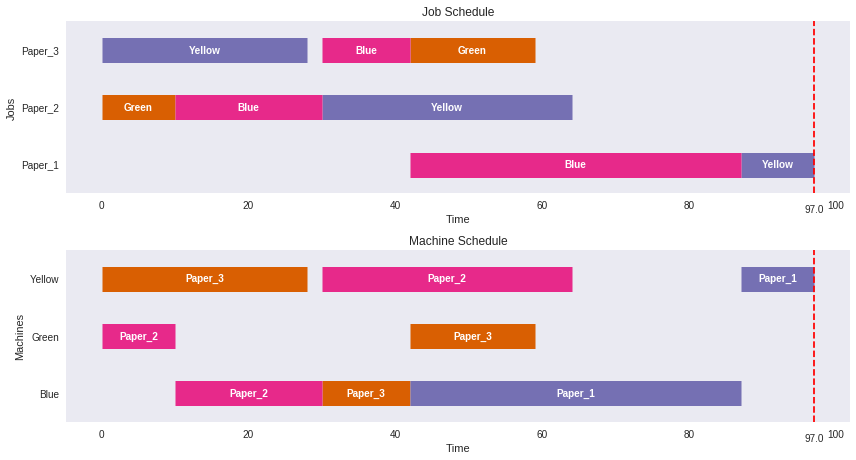

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

def Visualize(results):
    
    schedule = pd.DataFrame(results)
    JOBS = list(schedule['Job'].unique())
    MACHINES = list(schedule['Machine'].unique())
    makespan = schedule['Finish'].max()

    schedule.sort_values(by=['Job','Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    plt.figure(figsize=(12, 5 + (len(JOBS)+len(MACHINES))/4))
    plt.subplot(2,1,1)

    jdx = 0
    for j in sorted(JOBS):
        jdx += 1
        mdx = 0
        for m in MACHINES:
            mdx += 1
            c = mpl.cm.Dark2.colors[mdx%7]
            if (j,m) in schedule.index:
                plt.plot([schedule.loc[(j,m),'Start'],schedule.loc[(j,m),'Finish']],
                     [jdx,jdx],color = c,alpha=1.0,lw=25,solid_capstyle='butt')
                plt.text((schedule.loc[(j,m),'Start'] + schedule.loc[(j,m),'Finish'])/2.0,jdx,
                    m, color='white', weight='bold',
                    horizontalalignment='center', verticalalignment='center')
    
    plt.ylim(0.5,jdx+0.5)
    plt.title('Job Schedule')
    plt.gca().set_yticks(range(1,1+len(JOBS)))
    plt.gca().set_yticklabels(sorted(JOBS))
    plt.plot([makespan,makespan],plt.ylim(),'r--')
    plt.text(makespan,plt.ylim()[0]-0.2,str(round(makespan,2)),
            horizontalalignment='center', verticalalignment='top')
    plt.xlabel('Time')
    plt.ylabel('Jobs')
    plt.grid()
    
    plt.subplot(2,1,2)
    mdx = 0
    for m in sorted(MACHINES):
        mdx += 1
        jdx = 0
        for j in JOBS:
            jdx += 1
            c = mpl.cm.Dark2.colors[jdx%7]
            if (j,m) in schedule.index:
                plt.plot([schedule.loc[(j,m),'Start'],schedule.loc[(j,m),'Finish']],
                     [mdx,mdx],color = c,alpha=1.0,lw=25,solid_capstyle='butt')
                plt.text((schedule.loc[(j,m),'Start'] + schedule.loc[(j,m),'Finish'])/2.0,mdx,
                    j, color='white', weight='bold',
                    horizontalalignment='center', verticalalignment='center')

    plt.ylim(0.5,mdx+0.5)
    plt.title('Machine Schedule')
    plt.gca().set_yticks(range(1,1+len(MACHINES)))
    plt.gca().set_yticklabels(sorted(MACHINES))
    plt.plot([makespan,makespan],plt.ylim(),'r--')
    plt.text(makespan,plt.ylim()[0]-0.2,str(round(makespan,2)),
            horizontalalignment='center', verticalalignment='top')
    plt.xlabel('Time')
    plt.ylabel('Machines')
    plt.grid()
    
    plt.tight_layout()

Visualize(results)

<a id="BatchProcesses"></a>
## Application to Scheduling of Batch Processes

We will now turn our attention to the application of the job shop scheduling problem to the short term scheduling of batch processes. We illustrate these techniques using an example from Dunn (2013).

![Screen%20Shot%202017-09-14%20at%209.09.57%20AM.png](attachment:Screen%20Shot%202017-09-14%20at%209.09.57%20AM.png)

| Process | Mixer | Reactor | Separator | Packaging |
| :-----: | :---: | :-----: | :-------: | :-------: |
| A       | 1.0   | 5.0     | 4.0       | 1.5       |
| B       | -     | -       | 4.5       | 1.0       |
| C       | -     | 3.0     | 5.0       | 1.5       |

<a id="SingleProduct"></a>
## Single Product Strategies

Before going further, we create a function to streamline the generation of the TASKS dictionary.

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -printingOptions all -import /content/tmpcfz20so5.pyomo.lp -stat=1 -solve -solu /content/tmpcfz20so5.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-8) rows, 0 (-6) columns and 0 (-15) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 21969 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-8) rows, 0 (-6) columns and 0 (-15) elements
E

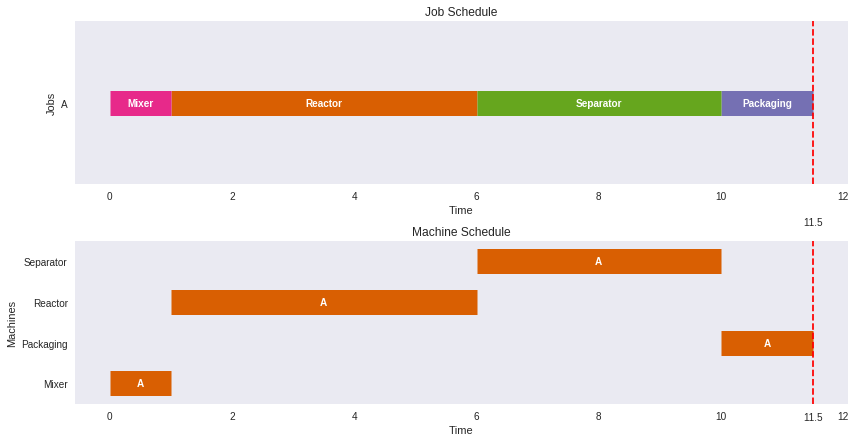

In [21]:
def Recipe(jobs,machines,durations):
    TASKS = {}
    for j in jobs:
        prec = (None,None)
        for m,d in zip(machines,durations):
            task = (j,m)
            if prec == (None,None):
                TASKS.update({(j,m): {'dur': d, 'prec': None}})
            else:
                TASKS.update({(j,m): {'dur': d, 'prec': prec}})
            prec = task
    return TASKS
        
RecipeA = Recipe('A',['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
RecipeB = Recipe('B',['Separator','Packaging'],[4.5,1])
RecipeC = Recipe('C',['Separator','Reactor','Packaging'],[5,3,1.5])

Visualize(JobShop(RecipeA))

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -printingOptions all -import /content/tmpzlj1hluu.pyomo.lp -stat=1 -solve -solu /content/tmpzlj1hluu.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-4) rows, 0 (-4) columns and 0 (-7) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 21875 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-4) rows, 0 (-4) columns and 0 (-7) elements
Emp

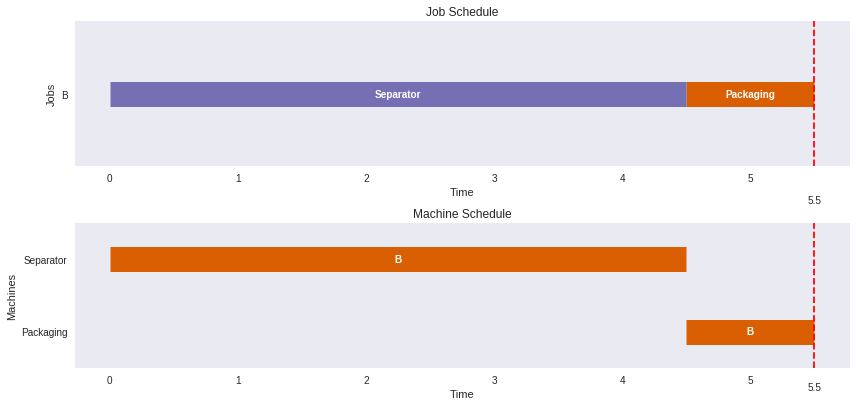

In [22]:
Visualize(JobShop(RecipeB))

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -printingOptions all -import /content/tmpdh9ewics.pyomo.lp -stat=1 -solve -solu /content/tmpdh9ewics.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-6) rows, 0 (-5) columns and 0 (-11) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 22010 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-6) rows, 0 (-5) columns and 0 (-11) elements
E

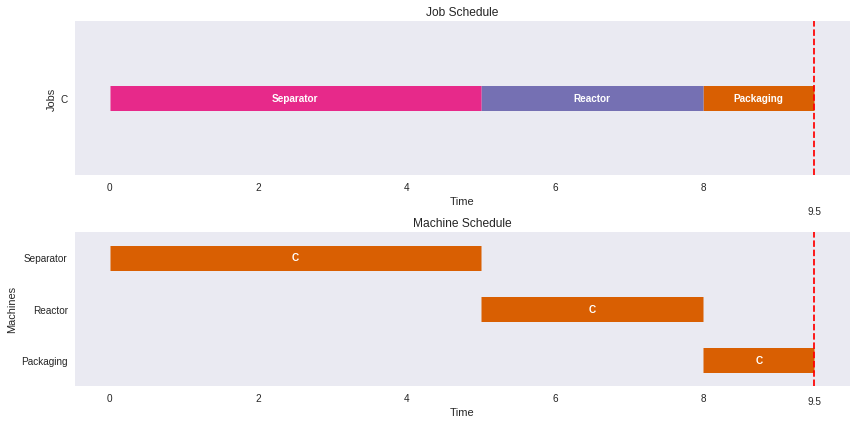

In [23]:
Visualize(JobShop(RecipeC))

<a id="OverlappingTasks"></a>
## Overlapping Tasks

Let's now consider an optimal scheduling problem where we are wish to make two batches of Product A.

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -printingOptions all -import /content/tmpplwxcn7l.pyomo.lp -stat=1 -solve -solu /content/tmpplwxcn7l.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 36 (-15) rows, 19 (-15) columns and 90 (-27) elements
Statistics for presolved model
Original problem has 8 integers (8 of which binary)
Presolved problem has 4 integers (4 of which binary)
==== 18 zero objective 2 different
18 variables have objective of 0
1 variables have objective of 1
==== absolute objective values 2 different
18 variables have objective of 0
1 variables have objective of 1
==== for integers 4 zero objective 1 different
4 variables have objective of 0
==== for integers absolute objective values 1 different
4 variables have objective of 0
===== end objective counts


Problem has 36 rows, 19 columns (1 with objective) and 90 elements
Column breakdown:
0 of type 0.0->inf, 15 

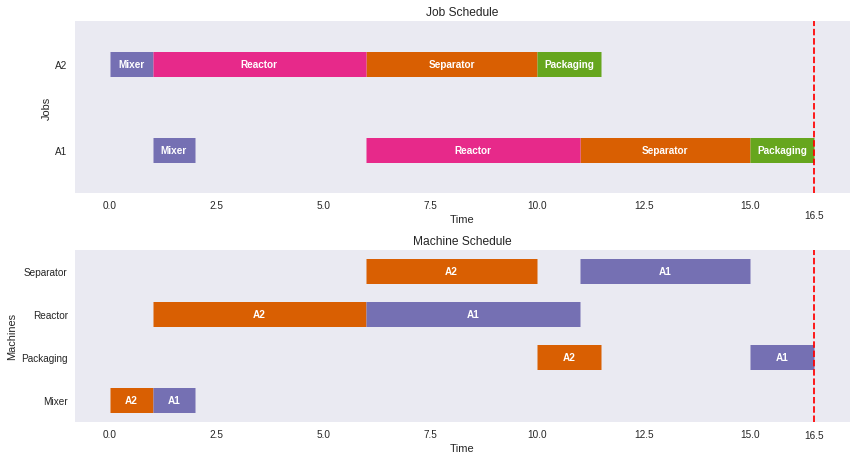

In [24]:
TASKS = Recipe(['A1','A2'],['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
results = JobShop(TASKS)
Visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

Earlier we found it tood 11.5 hours to produce one batch of product A.  As we see here, we can produce a second batch with only 5.0 additional hours because some of the tasks overlap.  The overlapping of tasks is the key to gaining efficiency in batch processing facilities.

Let's next consider production of a single batch each of products A, B, and C.

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -printingOptions all -import /content/tmpwgfw9r8o.pyomo.lp -stat=1 -solve -solu /content/tmpwgfw9r8o.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 55 (-24) rows, 30 (-23) columns and 152 (-33) elements
Statistics for presolved model
Original problem has 14 integers (14 of which binary)
Presolved problem has 7 integers (7 of which binary)
==== 29 zero objective 2 different
29 variables have objective of 0
1 variables have objective of 1
==== absolute objective values 2 different
29 variables have objective of 0
1 variables have objective of 1
==== for integers 7 zero objective 1 different
7 variables have objective of 0
==== for integers absolute objective values 1 different
7 variables have objective of 0
===== end objective counts


Problem has 55 rows, 30 columns (1 with objective) and 152 elements
Column breakdown:
0 of type 0.0->inf,

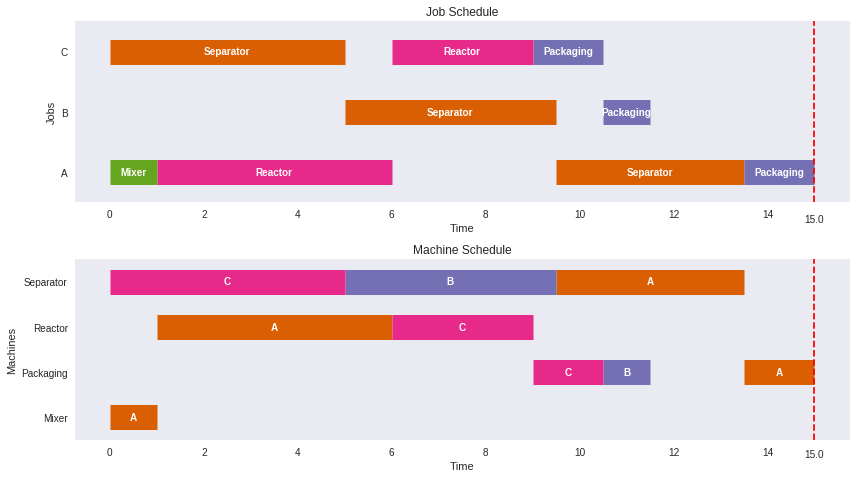

In [25]:
TASKS = RecipeA
TASKS.update(RecipeB)
TASKS.update(RecipeC)

results = JobShop(TASKS)
Visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

The individual production of A, B, and C required 11.5, 5.5, and 9.5 hours, respectively, for a total of 25.5 hours. As we see here, by scheduling the production simultaneously, we can get all three batches done in just 15 hours. 

As we see below, each additional set of three products takes an additionl 13 hours.  So there is considerable efficiency gained by scheduling over longer intervals whenever possible.

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -printingOptions all -import /content/tmplnlptrn8.pyomo.lp -stat=1 -solve -solu /content/tmplnlptrn8.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 250 (-114) rows, 128 (-114) columns and 716 (-159) elements
Statistics for presolved model
Original problem has 74 integers (74 of which binary)
Presolved problem has 37 integers (37 of which binary)
==== 127 zero objective 2 different
127 variables have objective of 0
1 variables have objective of 1
==== absolute objective values 2 different
127 variables have objective of 0
1 variables have objective of 1
==== for integers 37 zero objective 1 different
37 variables have objective of 0
==== for integers absolute objective values 1 different
37 variables have objective of 0
===== end objective counts


Problem has 250 rows, 128 columns (1 with objective) and 716 elements
Column breakdown:
0 of

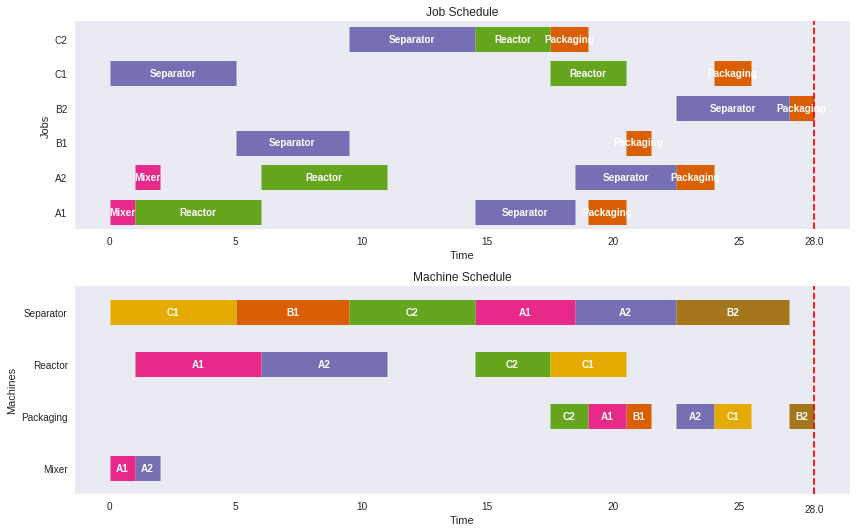

In [26]:
TASKS = Recipe(['A1','A2'],['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
TASKS.update(Recipe(['B1','B2'],['Separator','Packaging'],[4.5,1]))
TASKS.update(Recipe(['C1','C2'],['Separator','Reactor','Packaging'],[5,3,1.5]))

results = JobShop(TASKS)
Visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

<a id="UnitCleanout"></a>
## Unit Cleanout

A common feature in batch unit operations is a requirement that equipment be cleaned prior to reuse. 

In most cases the time needed for clean out would be equipment and product specific. Bur for the purposes of illustration, we implement this policy with a single non-negative parameter $t_{clean} \geq 0$ which, if specified, requires a period no less than $t_{clean}$ between the finish of one task and the start of another on every piece of equipment.

This is implemented by modifying the usual disjunctive constraints to avoid machine conflicts, i.e.,

\begin{align}
\text{start}_{j,m}+\text{Dur}_{j,m} & \leq \text{start}_{k,m}+M(1 - y_{j,k,m})\\
\text{start}_{k,m}+\text{Dur}_{k,m} & \leq \text{start}_{j,m}+My_{j,k,m}
\end{align}

to read

\begin{align}
\text{start}_{j,m}+\text{Dur}_{j,m} + t_{clean} & \leq \text{start}_{k,m}+M(1 - y_{j,k,m})\\
\text{start}_{k,m}+\text{Dur}_{k,m} + t_{clean} & \leq \text{start}_{j,m}+My_{j,k,m}
\end{align}

for sufficiently large $M$.

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -printingOptions all -import /content/tmpx1kl3mxv.pyomo.lp -stat=1 -solve -solu /content/tmpx1kl3mxv.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 250 (-114) rows, 128 (-114) columns and 716 (-159) elements
Statistics for presolved model
Original problem has 74 integers (74 of which binary)
Presolved problem has 37 integers (37 of which binary)
==== 127 zero objective 2 different
127 variables have objective of 0
1 variables have objective of 1
==== absolute objective values 2 different
127 variables have objective of 0
1 variables have objective of 1
==== for integers 37 zero objective 1 different
37 variables have objective of 0
==== for integers absolute objective values 1 different
37 variables have objective of 0
===== end objective counts


Problem has 250 rows, 128 columns (1 with objective) and 716 elements
Column breakdown:
0 of

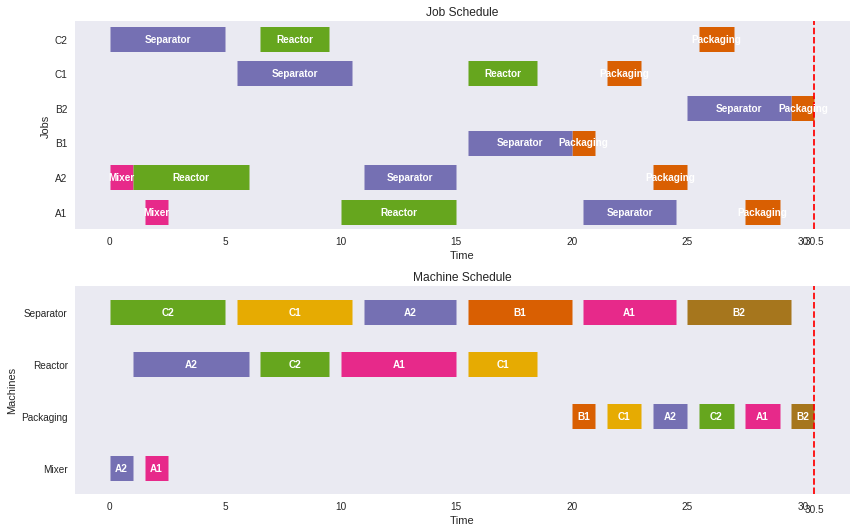

In [27]:
def JobShop(TASKS, tclean=0):
    
    model = ConcreteModel()
    
    model.TASKS    = Set(initialize=TASKS.keys(), dimen=2)
    model.JOBS     = Set(initialize=set([j for (j,m) in TASKS.keys()]))
    model.MACHINES = Set(initialize=set([m for (j,m) in TASKS.keys()]))
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4,
        filter = lambda model,j,m,k,n: (k,n) == TASKS[(j,m)]['prec'])
    model.DISJUNCTIONS = Set(initialize=model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model,j,k,m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    t_max = sum([TASKS[(j,m)]['dur'] for (j,m) in TASKS.keys()])
    
    model.makespan = Var(bounds=(0, t_max))
    model.start = Var(model.TASKS, bounds=(0, t_max))

    model.obj = Objective(expr = model.makespan, sense = minimize)

    model.fini = Constraint(model.TASKS, rule=lambda model,j,m: 
        model.start[j,m] + TASKS[(j,m)]['dur'] <= model.makespan)
    
    model.prec = Constraint(model.TASKORDER, rule=lambda model,j,m,k,n:
        model.start[k,n] + TASKS[(k,n)]['dur'] <= model.start[j,m])
    
    model.disj = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + TASKS[(j,m)]['dur'] + tclean <= model.start[k,m],
         model.start[k,m] + TASKS[(k,m)]['dur'] + tclean <= model.start[j,m]])

    TransformationFactory('gdp.chull').apply_to(model)
    solver.solve(model, tee=True)

    results = [{'Job': j,
                'Machine': m,
                'Start': model.start[j, m](), 
                'Duration': TASKS[(j, m)]['dur'], 
                'Finish': model.start[j, m]() + TASKS[(j, m)]['dur']}
               for j,m in model.TASKS]
    return results
    
results = JobShop(TASKS, tclean=0.5)
Visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

<a id="ZeroWait"></a>
## Zero Wait Policy

One of the issues in the use of job shop scheduling for batch processing are situations where there it isn't possible to store intermediate materials. If there is no way to store intermediates, either in the processing equipment or in external vessels, then a **zero-wait** policy may be appropriate. 

A zero-wait policy requires subsequent processing machines to be available immediately upon completion of any task. To implement this policy, the usual precident sequencing constraint of a job shop scheduling problem, i.e.,

\begin{align*}
\text{start}_{k,n}+\text{Dur}_{k,n} \leq \text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{Prec}_{j,m}
\end{align*}

is changed to 

\begin{align*}
\text{start}_{k,n}+\text{Dur}_{k,n} = \text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{Prec}_{j,m}\text{ and ZW is True}
\end{align*}

if the zero-wait policy is in effect. 

While this could be implemented on an equipment or product specific basis, here we add an optional ZW flag to the JobShop function that, by default, is set to False.

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -printingOptions all -import /content/tmpot_a5ctn.pyomo.lp -stat=1 -solve -solu /content/tmpot_a5ctn.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 228 (-136) rows, 118 (-124) columns and 678 (-197) elements
Statistics for presolved model
Original problem has 74 integers (74 of which binary)
Presolved problem has 37 integers (37 of which binary)
==== 117 zero objective 2 different
117 variables have objective of 0
1 variables have objective of 1
==== absolute objective values 2 different
117 variables have objective of 0
1 variables have objective of 1
==== for integers 37 zero objective 1 different
37 variables have objective of 0
==== for integers absolute objective values 1 different
37 variables have objective of 0
===== end objective counts


Problem has 228 rows, 118 columns (1 with objective) and 678 elements
Column breakdown:
0 of

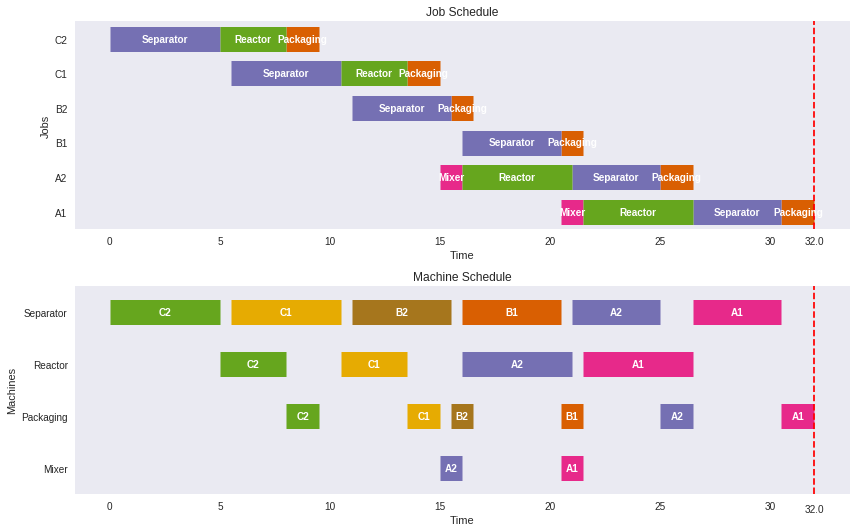

In [28]:
def JobShop(TASKS, tclean=0, ZW=False):
    
    model = ConcreteModel()
    
    model.TASKS    = Set(initialize=TASKS.keys(), dimen=2)
    model.JOBS     = Set(initialize=set([j for (j,m) in TASKS.keys()]))
    model.MACHINES = Set(initialize=set([m for (j,m) in TASKS.keys()]))
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4,
        filter = lambda model,j,m,k,n: (k,n) == TASKS[(j,m)]['prec'])
    model.DISJUNCTIONS = Set(initialize=model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model,j,k,m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    t_max = sum([TASKS[(j,m)]['dur'] for (j,m) in TASKS.keys()])
    
    model.makespan = Var(bounds=(0, t_max))
    model.start = Var(model.TASKS, bounds=(0, t_max))

    model.obj = Objective(expr = model.makespan, sense = minimize)

    model.fini = Constraint(model.TASKS, rule=lambda model,j,m: 
        model.start[j,m] + TASKS[(j,m)]['dur'] <= model.makespan)
    
    if ZW:
        model.prec = Constraint(model.TASKORDER, rule=lambda model,j,m,k,n:
            model.start[k,n] + TASKS[(k,n)]['dur'] == model.start[j,m])
    else:
        model.prec = Constraint(model.TASKORDER, rule=lambda model,j,m,k,n:
            model.start[k,n] + TASKS[(k,n)]['dur'] <= model.start[j,m])        
    
    model.disj = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + TASKS[(j,m)]['dur'] + tclean <= model.start[k,m],
         model.start[k,m] + TASKS[(k,m)]['dur'] + tclean <= model.start[j,m]])

    TransformationFactory('gdp.chull').apply_to(model)
    solver.solve(model, tee=True)

    results = [{'Job': j,
                'Machine': m,
                'Start': model.start[j, m](), 
                'Duration': TASKS[(j, m)]['dur'], 
                'Finish': model.start[j, m]() + TASKS[(j, m)]['dur']}
               for j,m in model.TASKS]
    return results
    
results = JobShop(TASKS, tclean=0.5, ZW=True)
Visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

<a id="Benchmark"></a>
## Benchmark Problems

The file `jobshop1.txt` (available [here](http://people.brunel.ac.uk/~mastjjb/jeb/orlib/files/jobshop1.txt)) is a well known collection of 82 benchmark problems for job shop scheduling. The data format for each example consists of a single line for each job.  The data on each line is a sequence of (machine number, time) pairs showing the order in which machines process each job.

LA19 is a benchmark problem for job shop scheduling introduced by Lawrence in 1984, and a solution presented by Cook and Applegate in 1991. The following cell may take many minutes to hours to run, depending on the choice of solver and hardware.

In [29]:
data = """
2  44  3   5  5  58  4  97  0   9  7  84  8  77  9  96  1  58  6  89
4  15  7  31  1  87  8  57  0  77  3  85  2  81  5  39  9  73  6  21
9  82  6  22  4  10  3  70  1  49  0  40  8  34  2  48  7  80  5  71
1  91  2  17  7  62  5  75  8  47  4  11  3   7  6  72  9  35  0  55
6  71  1  90  3  75  0  64  2  94  8  15  4  12  7  67  9  20  5  50
7  70  5  93  8  77  2  29  4  58  6  93  3  68  1  57  9   7  0  52
6  87  1  63  4  26  5   6  2  82  3  27  7  56  8  48  9  36  0  95
0  36  5  15  8  41  9  78  3  76  6  84  4  30  7  76  2  36  1   8
5  88  2  81  3  13  6  82  4  54  7  13  8  29  9  40  1  78  0  75
9  88  4  54  6  64  7  32  0  52  2   6  8  54  5  82  3   6  1  26
"""

TASKS = {}
prec = ''

lines = data.splitlines()
job= 0
for line in lines[1:]:
    j = "J{0:1d}".format(job)
    nums = line.split()
    prec = ''
    for m,dur in zip(nums[::2],nums[1::2]):
        task = (j,'M{0:s}'.format(m))
        if prec:
            TASKS[task] = {'dur':int(dur), 'prec':prec}
        else:
            TASKS[task] = {'dur':int(dur), 'prec':None}
        prec = task
    job += 1
    
Visualize(JobShop(TASKS))

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -printingOptions all -import /content/tmpbbtjnn1w.pyomo.lp -stat=1 -solve -solu /content/tmpbbtjnn1w.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 2890 (-1351) rows, 1451 (-1351) columns and 8480 (-1801) elements
Statistics for presolved model
Original problem has 900 integers (900 of which binary)
Presolved problem has 450 integers (450 of which binary)
==== 1450 zero objective 2 different
1450 variables have objective of 0
1 variables have objective of 1
==== absolute objective values 2 different
1450 variables have objective of 0
1 variables have objective of 1
==== for integers 450 zero objective 1 different
450 variables have objective of 0
==== for integers absolute objective values 1 different
450 variables have objective of 0
===== end objective counts


Problem has 2890 rows, 1451 columns (1 with objective) and 8480 elements
Col

ApplicationError: ignored

### Recalculate Benchmark Problem with a Zero-Wait Policy

The following calculation is quite intensive and will take several minutes to finish with the `gurobi` solver. 

Academic license - for non-commercial use only
Optimize a model with 4241 rows, 2802 columns and 10281 nonzeros
Variable types: 1902 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 5e+03]
  RHS range        [1e+00, 1e+02]
Presolve removed 1531 rows and 1441 columns
Presolve time: 0.02s
Presolved: 2710 rows, 1361 columns, 8120 nonzeros
Variable types: 911 continuous, 450 integer (450 binary)

Root relaxation: objective 6.200000e+02, 485 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  620.00000    0   64          -  620.00000      -     -    0s
     0     0  640.56756    0   87          -  640.56756      -     -    0s
     0     0  650.03766    0   94          -  650.03766      -     -    0s
     0     0  650.03766    0   88          -  650.

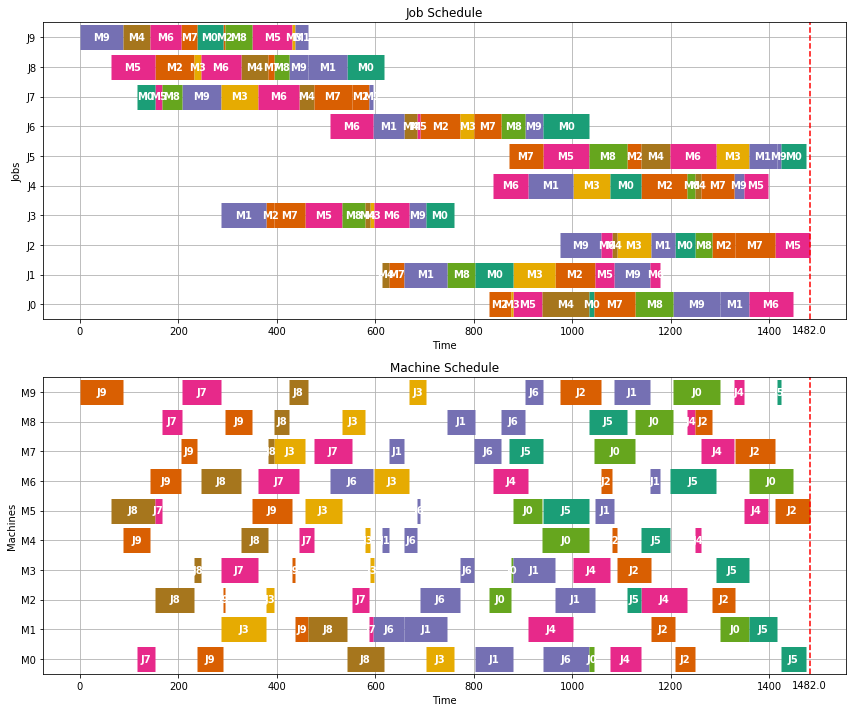

In [0]:
Visualize(JobShop(TASKS, ZW=True))